# **Urban Layout Analysis**
This notebook contains analysis for classifying urban layout typologies and generating composite urban layouts

Not all files are available for download as the model architecture are pending publication.


## **Set up**

In [3]:
!pip install geopandas
import glob
import math
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import copy
import time
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set_theme()
import matplotlib.patches as patches
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry.polygon import Point, Polygon
matplotlib_axes_logger.setLevel('ERROR')

In [4]:
# load required files
path = 'city_layout_analysis/'
latent_ori = torch.load(path+'latent_ori.pt')
city_layouts = pd.read_csv(path+'city_layouts.csv',index_col=0)
results = pd.read_csv(path+'results.csv',header=None)

In [5]:
def inference_final_set(P, F, n, out=[]):
    '''
    Input:
        P: Positions of initial node  n*3
        F: Features of initial node  n*d
        n: Max level of generated tree
    Output:
        out: Position List of generated children nodes
    ''' 
    if(n == 0):
        return out
    P_list = []
    P_list_re = []
    I_list = []
    leaf_node_list = []
    
    tmp_P = P
    tmp_F = F
    father_I = torch.zeros((1,1))
    P_list.append(P[0])

    for i in range(n):
        left_featrue, left_P, left_isleaf, right_featrue, right_P, right_isleaf = model.decoder(tmp_F, tmp_P)
        
        left_xy_new = left_P[:,:2] * tmp_P[:,2:4] + tmp_P[:,:2]
        left_P[:,:2] = left_xy_new
        left_wh_new = left_P[:,2:4] * tmp_P[:,2:4]
        left_P[:,2:4] = left_wh_new
        left_a_new = left_P[:,4] + tmp_P[:,4]
        left_P[:,4] = left_a_new
        
        right_xy_new = right_P[:,:2] * tmp_P[:,2:4] + tmp_P[:,:2]
        right_P[:,:2] = right_xy_new
        right_wh_new = right_P[:,2:4] * tmp_P[:,2:4]
        right_P[:,2:4] = right_wh_new
        right_a_new = right_P[:,4] + tmp_P[:,4]
        right_P[:,4] = right_a_new
        
        I = np.zeros(len(left_P)*2, dtype='int32')
        
        temp_I_list = []
        left_node_index = torch.zeros((len(left_P),1))
        right_node_index = torch.zeros((len(right_P),1))
        
        for j in range(len(left_P)):
            
            P_list.append(left_P[j])
            left_index =len(P_list) -1
            P_list.append(right_P[j])
            right_index =len(P_list) -1
            
            father_index = father_I[j].detach().numpy()
            father_index = int(father_index)
            temp_I = [left_index, right_index, father_index]
            
            I[2*j] = left_index
            I[2*j+1] = right_index
            left_node_index[j] = left_index
            right_node_index[j] = right_index

            temp_I_list.append(temp_I)
            
        if(temp_I_list):     
            I_list.append(temp_I_list) 
    
        tmp_F = []
        tmp_P = []
        father_I = []
        
        left_isleaf = torch.round(left_isleaf)[:,0]
        right_isleaf = torch.round(right_isleaf)[:,0]
        
        tmp_F.append(left_featrue[left_isleaf==0,:])
        tmp_P.append(left_P[left_isleaf==0,:])
        father_I.append(left_node_index[left_isleaf==0,:])
        
        tmp_F.append(right_featrue[right_isleaf==0,:])
        tmp_P.append(right_P[right_isleaf==0,:])
        father_I.append(right_node_index[right_isleaf==0,:])
        
        if(len(left_P[left_isleaf==1,:])>0):
            leaf_node_list.append(left_P[left_isleaf==1,:])
        if(len(right_P[right_isleaf==1,:])>0):
            leaf_node_list.append(right_P[right_isleaf==1,:])
        
        tmp_F = torch.cat(tmp_F, 0)
        tmp_P = torch.cat(tmp_P, 0)
        father_I = torch.cat(father_I, 0)

    P_list = torch.stack(P_list)
    leaf_node_list = torch.cat(leaf_node_list)
    return P_list, I_list, leaf_node_list

def rotate_xy_2(p, sin, cos, center):
    x_ = (p[:,0:1]-center[:,0:1])*cos-(p[:,1:2]-center[:,1:2])*sin+center[:,0:1]
    y_ = (p[:,0:1]-center[:,0:1])*sin+(p[:,1:2]-center[:,1:2])*cos+center[:,1:2]
    return np.hstack((x_, y_))

def get_box_2(P, F):
    ld = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    rd = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    ru = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    lu = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    sinO = np.sin(F[:,2:3])
    cosO = np.cos(F[:,2:3])

    ld_r = rotate_xy_2(ld, sinO, cosO, P)
    rd_r = rotate_xy_2(rd, sinO, cosO, P)
    ru_r = rotate_xy_2(ru, sinO, cosO, P)
    lu_r = rotate_xy_2(lu, sinO, cosO, P)
    if(len(P)>0):
        box_r = np.hstack((ld_r, rd_r, ru_r, lu_r)).reshape(len(P), -1, 2)
    else:
        box_r = []
    return box_r

def plot_boxes2(samples, n, m, A, B):
    fig = plt.figure(figsize=(5*m,5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            ax = fig.add_subplot(n, m, idx+1)
            draw_box2(samples[idx])  
    plt.savefig('combi_interpolation/{}_{}.png'.format(A,B),dpi=500)
    plt.show()

def plot_boxes3(samples, n, A, B):
    for idx in range(n):
        for i, pc in enumerate(samples[idx]):
            X, Y= pc[:, 0], pc[:,1]
            plt.plot(X, Y, c='b')
            plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c='b')
            plt.axis('equal')            
        plt.savefig('latent_interpolation/{}_{}_{}.png'.format(A, B, idx),dpi=300,pad_inches=0.0)
        plt.show()

def draw_polygon_c(pc, txt, center, color):
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    plt.axis('off')

def draw_box(box, txt, center, color):
    for i, p in enumerate(box):
        c = 'r' if color[i] else 'b'
        draw_polygon_c(p, txt[i], center[i], c)

def draw_box2(box):
    for i, p in enumerate(box):
        draw_polygon_c2(p)

def plot_boxes(samples, label, center, color, n, m, index):
    fig = plt.figure(figsize=(5*m,5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            ax = fig.add_subplot(n, m, idx+1)
            draw_box(samples[idx], label[idx], center[idx], color[idx])  
    plt.savefig('indiv_layouts/{}'.format(index))
    plt.show()

def draw_polygon_c2(pc, color='b'):
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    plt.axis('equal')

def draw_polygon_s(pc, w, c):
    
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, linewidth=w, color=c)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], linewidth =w, color=c)
    plt.axis('equal')
    plt.axis('off')

def draw_box_save(box, linewidth='3', color='mediumslateblue', name='gt'): 
    fig = plt.figure(figsize=(6,6))
    for i, p in enumerate(box):
        draw_polygon_s(p, linewidth, color)
    plt.savefig(name,bbox_inches='tight',dpi=300,pad_inches=0.0)

In [6]:
import model_ae_tree_box_ab2_new_re_weight_lstm_print
from model_ae_tree_box_ab2_new_re_weight_lstm_print import *

trainset = TreeData(data_folder="32boxes_coordinates.pickle", train=True, split=1, n_feature=512, num_box=32, batch_size=50)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)

model = AE.load_from_drive(AE, name=path+'tree_lstm_64_test_32box_2_best', model_dir='', device=torch.device('cuda'), n_feature=512)

In [7]:
all_features = {}
for i,v in enumerate(train_loader, 0):
    all_features[i] = v

In [8]:
def plot_box(train_index, idx):

  batch = train_index//50
  batch_num = train_index%50
  
  X, I_list, Feature, Node_is_leaf = all_features[batch]

  X = X.squeeze(0)
  Feature = Feature.squeeze(0)
  Node_is_leaf = Node_is_leaf.squeeze(0)
  X = X.float()
  Feature = Feature.float()

  Feature_New = model.encode(X, Feature, I_list)
  X_r, X_ab_xy, X_ab_xy_r, Feature_r, Loss_P, Loss_Leaf, Num, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)
  X_ab_xy = X_ab_xy.detach().numpy()

  N = 32 #change num_boxes
  N_total = 2*N-1
  X_tree0 = X_ab_xy[N_total*batch_num:N_total*(batch_num+1),:2]
  Feature_tree0 = X_ab_xy[N_total*batch_num:N_total*(batch_num+1),2:]

  box_list = []
  center_list = []
  txt_list = []
  color_list = []

  node_index = np.arange(N)
  color = np.zeros(len(node_index))
  P = X_tree0[node_index,:2]
  F = Feature_tree0[node_index]
  box = get_box_2(P,F)
  box_list.append(box)
  center_list.append(P)
  txt_list.append(node_index)
  color_list.append(color)  

  plot_boxes(box_list, txt_list, center_list, color_list, 1, 1, idx)

## **Classifying Urban Layout Typologies**
This performs dimensionality reduction and clustering on the latent space, to define the urban layout typologies.

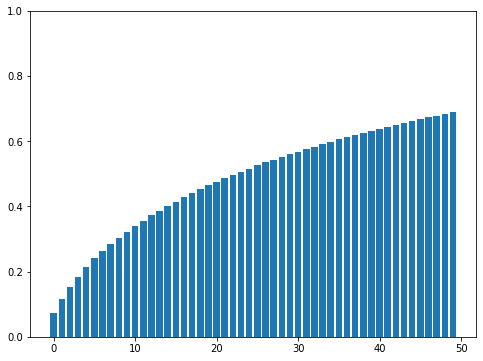

0.5159389655623823
0.6879578632570872


In [11]:
# principal component analysis of the latent space
sc = StandardScaler()
latentS = sc.fit_transform(torch.reshape(latent_ori,(45000,512)))

pca = PCA(n_components=50)
city_layout = pca.fit_transform(latentS)
plt.figure(figsize=(8,6))
plt.bar(np.arange(50),pca.explained_variance_ratio_.cumsum())
plt.ylim([0,1])
plt.show()

# top 25 components explain >50% of variance
print(np.sum(pca.explained_variance_ratio_[:25]))

# top 50 components explain >68% of variance
print(np.sum(pca.explained_variance_ratio_))

In [12]:
layouts = pd.read_csv(path+'city_layouts_with_clustering.csv',index_col=0)
layouts.head()

,index,x,y,zipcode,nta,gmm
0,26489,9.991029e+05,235735.892554,10027,Central Harlem North-Polo Grounds,4
1,41270,9.834253e+05,203571.228461,10012,SoHo-TriBeCa-Civic Center-Little Italy,10
2,35657,9.898435e+05,214944.631124,10036,Midtown-Midtown South,3
3,18133,9.985651e+05,221002.182447,10028,Yorkville,0
4,16208,1.001484e+06,229830.613688,10035,East Harlem North,7


In [13]:
# using t-SNE to map the higher dimensional components onto a lower dimensional space
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=50.0)

latents = pd.DataFrame(city_layout)
latents['latent_index'] = latents.index
latents['cluster'] = layouts.gmm

latent_sample = latents.sample(frac=0.2)

X_tsne = tsne.fit_transform(latent_sample.iloc[:,:20])
X_tsne_data = np.vstack((X_tsne.T,latent_sample.latent_index,latent_sample.cluster)).T
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2','latent_index','cluster'])
df_tsne.head()

,Dim1,Dim2,latent_index,cluster
0,-21.344625,-28.538689,19176.0,9.0
1,-36.701706,-37.356121,1323.0,7.0
2,-6.506228,-2.105388,23092.0,3.0
3,3.163108,-40.432747,9952.0,7.0
4,30.460882,-6.569711,11019.0,7.0


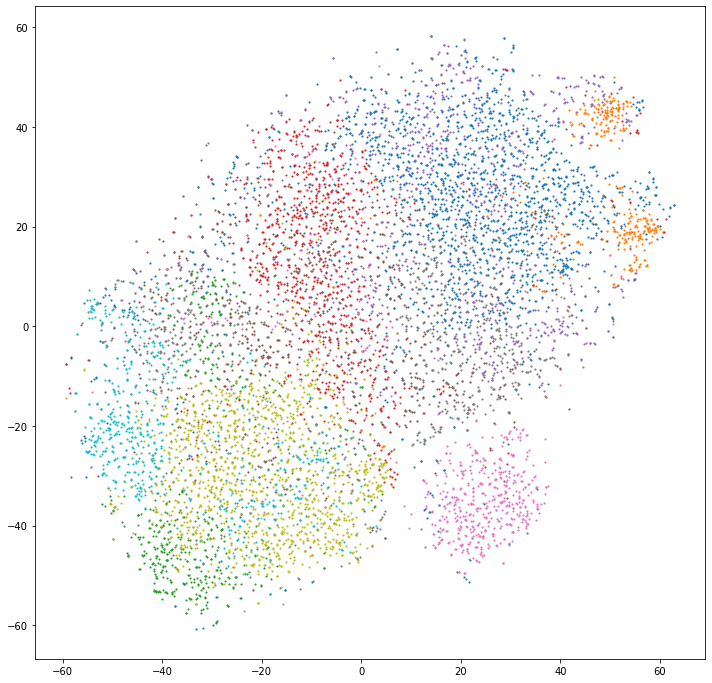

In [14]:
fig = plt.figure(1, figsize=(12,12))
for i in range(11):
  plt.scatter(df_tsne[df_tsne.cluster==i]['Dim1'],
              df_tsne[df_tsne.cluster==i]['Dim2'],label=i,marker='.',s=5)

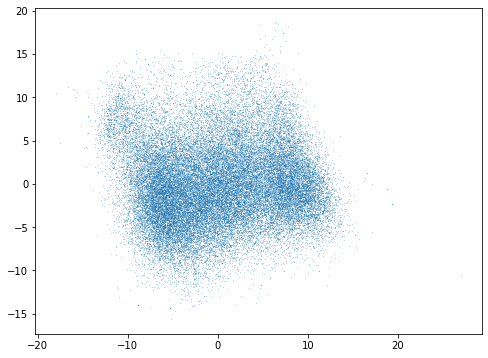

In [ ]:
# plotting the top two principal components in 2D space
city_layout = pd.DataFrame(city_layout)

fig = plt.figure(1, figsize=(8, 6))
plt.scatter(np.array(city_layout[0]), np.array(city_layout[1]),marker=".",s=0.05)
plt.show()

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
# cacluating the BIC for GMM clustering to optimize the number of clusters
n_clusters=np.arange(4, 14)
bics=[]
bics_err=[]
iterations=10
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=1,tol=1e-3,max_iter=50).fit(city_layout.iloc[:,:50])
        tmp_bic.append(gmm.bic(city_layout.iloc[:,:50]))
    val=np.mean(SelBest(np.array(tmp_bic), 1))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)
    print('Cluster {} done...'.format(n))

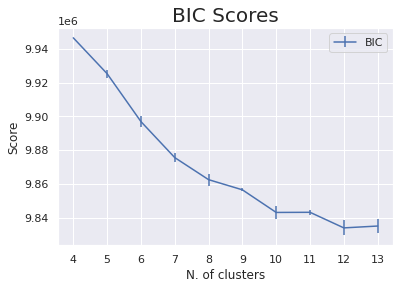

In [ ]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

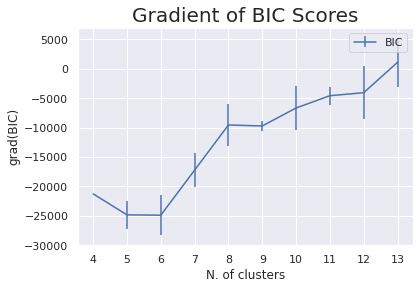

In [ ]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

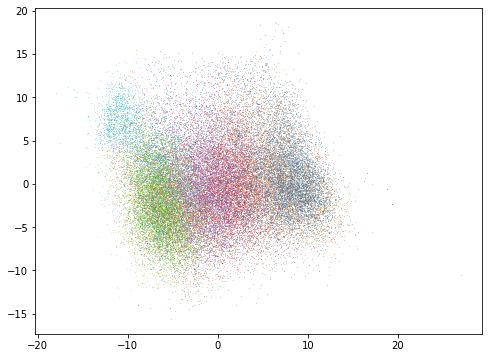

In [ ]:
# plotting GMM clusters based on top 50 principal components
n = 11
gm = GaussianMixture(n_components=n).fit(city_layout.iloc[:,:50])
city_layout['labels'] = 0
city_layout['labels'] = gm.predict(city_layout.iloc[:,:50])

fig = plt.figure(1, figsize=(8, 6))
for i in range(11):
  plt.scatter(np.array(city_layout[city_layout.labels==i][0]), np.array(city_layout[city_layout.labels==i][1]),label=i,marker=".",s=0.05)
# plt.legend()
plt.show()

## **Generating Composite Urban Layouts**
This takes the latent space of selected urban layouts (using their index) and performs latent interpolation between their tensor sets. Use for generating composite urban layouts.

In [9]:
latent_ori = torch.load(path+'latent_ori.pt')
root_P_list = torch.load('P_latent_ori.pt')

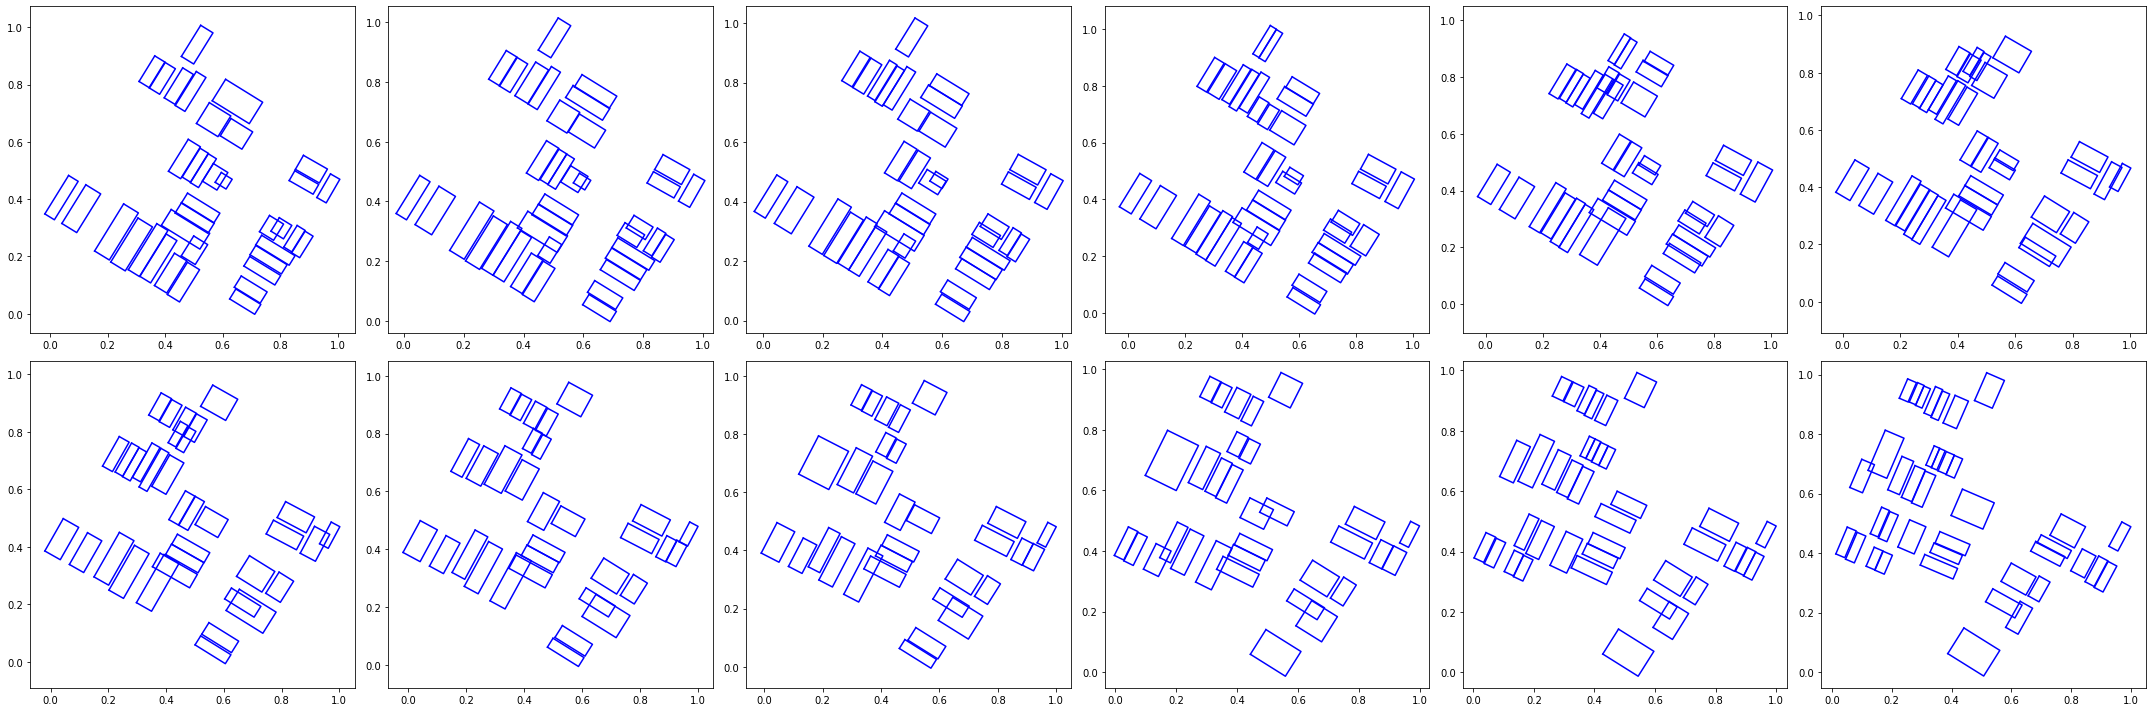

In [10]:
# index of the urban layouts
nta_A = 27
nta_B = 12

# retrieving the latent features of the urban layouts
latent0 = latent_ori[nta_A]
latent1 = latent_ori[nta_B]

# linear interpolation of the geometric and representational features
steps = [latent0]+[latent0 + x*(latent1-latent0) for x in torch.linspace(0.1, 0.8, steps=10)]+[latent1]
latent_steps = torch.stack(steps, dim=0)

P0 = torch.reshape(root_P_list[nta_A],(1,5))
P1 = torch.reshape(root_P_list[nta_B],(1,5))

p_steps = [P0]+[P0 + x*(P1-P0) for x in torch.linspace(0.1, 0.8, steps=10)]+[P1]
P_steps = torch.stack(p_steps, dim=0)

# decoding the linearly interpolated values
Box_Set_List = []
for i in range(12):
    P_list, I_list, Set_list = inference_final_set(P_steps[i],latent_steps[i:i+1], 20)
    Set_list = Set_list.detach().numpy()
    box_set = get_box_2(Set_list[:,:2],Set_list[:,2:])
    Box_Set_List.append(box_set)

# plotting the generation of composite urban layouts
plot_boxes2(Box_Set_List,2,6,0,1)

## **Evaluation - Expert Validation**
This calculates the cosine similarity of two latent spaces. It also contains the code for comparing the city layout similarity as calculated by latent space cosine similarity, compared to expert evaluation done by professional urban planners.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import re
sc = StandardScaler()

def cosine(set1,set2):
  a = latent_ori[set1].reshape(1,-1)
  b = latent_ori[set2].reshape(1,-1)
  return cosine_similarity(a,b)[0][0]

In [17]:
# retrieve pairs of urban layouts used for evaluation
filenames = [os.path.basename(x) for x in glob.glob('new_pair_evaluation/*.png')]
len(filenames)

50

In [18]:
# retrieve the index of urban layouts
pairs = []
for file in filenames:
  a = re.search(r'(?<=_)\w+', file)
  b = re.search(r'\w+(?=_)', file)
  set1 = city_layouts[city_layouts['index']==int(b[0])].index[0]
  set2 = city_layouts[city_layouts['index']==int(a[0])].index[0]
  
  # compute cosine similarity of urban layouts
  score = cosine(set1,set2)
  pairs.append([int(b[0]),int(a[0]),score])

In [19]:
# sort pairs to align with Qualitrics evaluation sequence
pairs.sort()
np.max([i[2] for i in pairs]) - np.min([i[2] for i in pairs])

0.3735472

In [20]:
# tabulating expert evaluation results and cosine similarity 
results = pd.read_csv(path+'results.csv',header=None)
results = results.transpose()
results['avg'] = results.mean(axis=1)/10.0
results['cosine'] = [i[2] for i in pairs]
results.head()

,0,1,2,3,4,5,6,7,avg,cosine
0,5,4,5,5,5,4,5,5,0.475,0.489011
1,5,4,5,5,5,4,5,5,0.475,0.489011
2,3,3,4,3,3,3,4,3,0.325,0.335757
3,6,6,7,6,6,6,7,6,0.625,0.557627
4,7,8,7,7,7,8,7,7,0.725,0.615223


In [21]:
# calculate normalized scores
for i in range(8):
  results['norm_{}'.format(i)] = results[i]/np.linalg.norm(results[i])
  
results['norm_avg'] = results.iloc[:,10:].mean(axis=1)/10.0
results['norm_cosine'] = results['cosine']/np.linalg.norm(results['cosine'])

std_score=np.mean(pd.DataFrame(sc.fit_transform(results.iloc[:,:8])),axis=1)

In [22]:
# convert to binary if above mean
results['cosine_b'] = [1 if results.iloc[i,9] > np.mean(results.cosine) else 0 for i in range(50)]
results['avg_b'] = [1 if results.iloc[i,8] > np.mean(results.avg) else 0 for i in range(50)]

# convert to binary if above mean + standard deviation
results['cosine_c'] = [1 if results.iloc[i,9] > (np.mean(results.cosine)+np.std(results.cosine)) else 0 for i in range(50)]
results['avg_c'] = [1 if results.iloc[i,8] > (np.mean(results.avg)+np.std(results.avg)) else 0 for i in range(50)]

# convert to binary if above mean - standard deviation
results['cosine_d'] = [1 if results.iloc[i,9] > (np.mean(results.cosine)-np.std(results.cosine)) else 0 for i in range(50)]
results['avg_d'] = [1 if results.iloc[i,8] > (np.mean(results.avg)-np.std(results.avg)) else 0 for i in range(50)]

In [23]:
# correlation of raw scores
np.corrcoef(results.avg,results.cosine)

# correlation of standardized scores
np.corrcoef(std_score,results.cosine)

array([[1.        , 0.43104738],
       [0.43104738, 1.        ]])

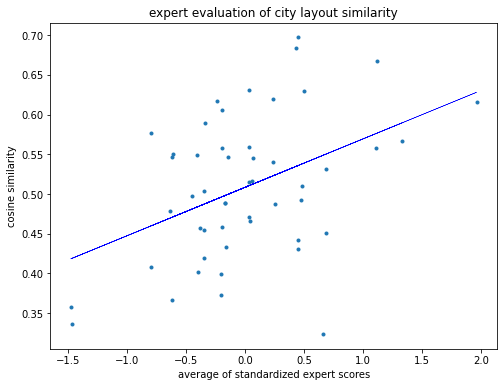

In [24]:
# plotting correlation statistics between expert evaluation and cosine similarity

m, b = np.polyfit(std_score,results.cosine,1)
plt.figure(figsize=(8,6))
plt.scatter(std_score,results.cosine,marker='.')
plt.plot(std_score, m*std_score + b,c='blue',linewidth=.5)
plt.ylabel("cosine similarity")
plt.xlabel("average of standardized expert scores")
plt.title("expert evaluation of city layout similarity")
plt.show()

In [25]:
# percentage correct if taking mean as threshold
wrong = 0
for i in range(50):
  if results.iloc[i,20] != results.iloc[i,21]:
    wrong += 1
print('% correct - mean as threshold:', round(1-(wrong/50.0),2))

# percentage correct if taking mean+std as threshold
wrong = 0
for i in range(50):
  if results.iloc[i,20] != results.iloc[i,23]:
    wrong += 1
print('% correct - mean+std as threshold:', round(1-(wrong/50.0),2))

# percentage correct if taking mean-std as threshold
wrong = 0
for i in range(50):
  if results.iloc[i,20] != results.iloc[i,25]:
    wrong += 1
print('% correct - mean-std as threshold:', round(1-(wrong/50.0),2))

% correct - mean as threshold: 0.66
% correct - mean+std as threshold: 0.56
% correct - mean-std as threshold: 0.54
